<a href="https://colab.research.google.com/github/rishantmallick/5-days-genai-hackathon/blob/main/llm_with_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 3.10.2 requires jupyterlab<4.0.0a0,>=3.1.0, which is not installed.
bigframes 1.42.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.18.0, which is not installed.
google-c

In [ ]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
class OrderState(TypedDict):
    messages : Annotated[list, add_messages]
    order: list[str]
    finished : bool


In [ ]:
from langchain_core.messages import HumanMessage, AIMessage

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!"
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}
graph_builder = StateGraph(OrderState)
# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)
# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")
chat_graph = graph_builder.compile()

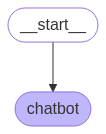

In [ ]:
from IPython.display import Image, display
Image(chat_graph.get_graph().draw_mermaid_png())

In [ ]:
from pprint import pprint
user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")


HumanMessage: Hello, what can you do?
AIMessage: Hi! I'm BaristaBot, and I can help you order from our cafe menu. We have a variety of delicious drinks and snacks to choose from. What are you interested in today?  Here's our menu:

**Drinks**

* **Espresso:** Our classic espresso, made with freshly roasted beans.
* **Americano:** Espresso with hot water.
* **Latte:** Espresso with steamed milk and a thin layer of foam.
* **Cappuccino:** Espresso with equal parts steamed milk and foamed milk.
* **Mocha:** Latte with chocolate syrup.
* **Caramel Macchiato:** Vanilla latte with caramel drizzle.
* **Iced Coffee:** Our signature blend, brewed fresh daily.
* **Tea:** A selection of hot teas.

**Modifiers**

* **Sugar:** Add sweetness to your drink.
* **Milk:** Choose from whole, skim, almond, or soy.
* **Syrups:** Vanilla, Caramel, Hazelnut, Chocolate.
* **Whipped Cream:** Add a dollop of whipped cream.
* **Ice:** Extra ice for your drink.

**Pastries**

* **Croissant:** Flaky, buttery, and 

In [ ]:
user_msg = "Oh great, what kinds of latte can you make?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi! I'm BaristaBot, and I can help you order from our cafe menu. We have a variety of delicious drinks and snacks to choose from. What are you interested in today?  Here's our menu:

**Drinks**

* **Espresso:** Our classic espresso, made with freshly roasted beans.
* **Americano:** Espresso with hot water.
* **Latte:** Espresso with steamed milk and a thin layer of foam.
* **Cappuccino:** Espresso with equal parts steamed milk and foamed milk.
* **Mocha:** Latte with chocolate syrup.
* **Caramel Macchiato:** Vanilla latte with caramel drizzle.
* **Iced Coffee:** Our signature blend, brewed fresh daily.
* **Tea:** A selection of hot teas.

**Modifiers**

* **Sugar:** Add sweetness to your drink.
* **Milk:** Choose from whole, skim, almond, or soy.
* **Syrups:** Vanilla, Caramel, Hazelnut, Chocolate.
* **Whipped Cream:** Add a dollop of whipped cream.
* **Ice:** Extra ice for your drink.

**Pastries**

* **Croissant:** Flaky, buttery, and 

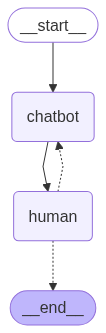

In [ ]:
def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)
    user_input = input("User: ")
    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True
    return state | {"messages": [("user", user_input)]}
def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""
    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)
    return state | {"messages": [new_output]}
graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");
from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())


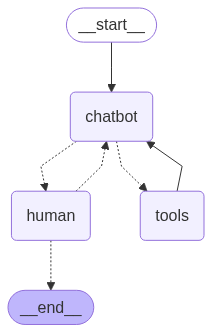

In [ ]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but you could connect this to a live stock
    # database, or you could use Gemini's multi-modal capabilities and take live photos of
    # your cafe's chalk menu or the products on the counter and assmble them into an input.

    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate

    Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
  """
    from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)
def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"
def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}
graph_builder = StateGraph(OrderState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [ ]:

config = {"recursion_limit": 100}
state = graph_with_menu.invoke({"messages": []}, config)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


User:  I want to order something


Model: Here is our menu:

MENU:
Coffee Drinks:
Espresso
Americano
Cold Brew

Coffee Drinks with Milk:
Latte
Cappuccino
Cortado
Macchiato
Mocha
Flat White

Tea Drinks:
English Breakfast Tea
Green Tea
Earl Grey

Tea Drinks with Milk:
Chai Latte
Matcha Latte
London Fog

Other Drinks:
Steamer
Hot Chocolate

Modifiers:
Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
Espresso shots: Single, Double, Triple, Quadruple; default: Double
Caffeine: Decaf, Regular; default: Regular
Hot-Iced: Hot, Iced; Default: Hot
Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

"dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
"Regular milk" is the same as 'whole milk'.
"Sweetened" me

User:  Matcha Latte


Model: OK. I have added a Matcha Latte to your order. Anything else?


User:  Almond Milk


Model: OK. I've added Almond Milk to your Matcha Latte. Anything else?


User:  no


Model: So you're order is a Matcha Latte with Almond Milk. Is that correct?


User:  yes


Model: Thank you for your order! It will be ready in approximately  minutes. Goodbye!


User:  quit


In [ ]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
class OrderState(TypedDict):
    messages : Annotated[list, add_messages]
    order: list[str]
    finished : bool

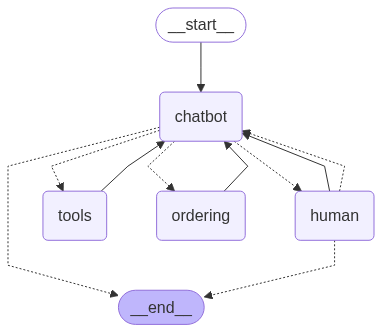

In [ ]:
from collections.abc import Iterable
from random import randint

from langchain_core.messages.tool import ToolMessage

# These functions have no body; LangGraph does not allow @tools to update
# the conversation state, so you will implement a separate node to handle
# state updates. Using @tools is still very convenient for defining the tool
# schema, so empty functions have been defined that will be bound to the LLM
# but their implementation is deferred to the order_node.

from langchain_core.messages.ai import AIMessage
def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)
    user_input = input("User: ")
    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True
    return state | {"messages": [("user", user_input)]}
@tool
def add_to_order(drink: str, modifiers: Iterable[str]) -> str:
    """Adds the specified drink to the customer's order, including any modifiers.

    Returns:
      The updated order in progress.
    """


@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """


@tool
def get_order() -> str:
    """Returns the users order so far. One item per line."""


@tool
def clear_order():
    """Removes all items from the user's order."""


@tool
def place_order() -> int:
    """Sends the order to the barista for fulfillment.

    Returns:
      The estimated number of minutes until the order is ready.
    """


def order_node(state: OrderState) -> OrderState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_order":

            # Each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
            modifiers = tool_call["args"]["modifiers"]
            modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"

            order.append(f'{tool_call["args"]["drink"]} ({modifier_str})')
            response = "\n".join(order)

        elif tool_call["name"] == "confirm_order":

            # We could entrust the LLM to do order confirmation, but it is a good practice to
            # show the user the exact data that comprises their order so that what they confirm
            # precisely matches the order that goes to the kitchen - avoiding hallucination
            # or reality skew.

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.

            print("Your order:")
            if not order:
                print("  (no items)")

            for drink in order:
                print(f"  {drink}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_order":

            response = "\n".join(order) if order else "(no order)"

        elif tool_call["name"] == "clear_order":

            order.clear()
            response = None

        elif tool_call["name"] == "place_order":

            order_text = "\n".join(order)
            print("Sending order to kitchen!")
            print(order_text)

            # TODO(you!): Implement cafe.
            order_placed = True
            response = randint(1, 5)  # ETA in minutes

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}

def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}
def maybe_route_to_tools(state: OrderState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"
# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# Order-tools will be handled by the order node.
order_tools = [add_to_order, confirm_order, get_order, clear_order, place_order]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(auto_tools + order_tools)


graph_builder = StateGraph(OrderState)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")
graph_builder.add_edge("human","chatbot")
graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Image(graph_with_order_tools.get_graph().draw_mermaid_png())

In [ ]:
state = graph_with_order_tools.invoke({"messages": []}, config)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


User:  I want to order something


Model: Great! Here's our menu:

MENU:
Coffee Drinks:
Espresso
Americano
Cold Brew

Coffee Drinks with Milk:
Latte
Cappuccino
Cortado
Macchiato
Mocha
Flat White

Tea Drinks:
English Breakfast Tea
Green Tea
Earl Grey

Tea Drinks with Milk:
Chai Latte
Matcha Latte
London Fog

Other Drinks:
Steamer
Hot Chocolate

Modifiers:
Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
Espresso shots: Single, Double, Triple, Quadruple; default: Double
Caffeine: Decaf, Regular; default: Regular
Hot-Iced: Hot, Iced; Default: Hot
Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

"dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
"Regular milk" is the same as 'whole milk'.
"Sweeten

User:  Macchiato


Model: Got it. Anything else?


User:  And a hot chocolate


Model: OK. Anything else?


User:  No


Your order:
  Macchiato (no modifiers)
  Hot Chocolate (no modifiers)


Is this correct?  Yes


Model: So you're ordering a Macchiato and a Hot Chocolate. Is that correct?


User:  Yes


Sending order to kitchen!
Macchiato (no modifiers)
Hot Chocolate (no modifiers)
